# PINN Solution of the Cahn Hilliard PDE

This PyTorch code demonstrates the application of physically-informed neural networks (PINN) in the solution of a well-known Cahn Hillard PDE with periodic boundary condition
\begin{aligned}
  &u_t = \epsilon_1(-u_{xx}  - \epsilon_2u_{xxxx} + (u^3)_{xx}), \quad (t, x) \in [0, T]\times[-L, L]\\
  &u(0, x) = u_0(x), \quad \forall x \in [-L, L] \\
  &u(t, -L) = u(t, L), \quad \forall t \in [0, T]
\end{aligned}
where $\epsilon_1, \epsilon-2 > 0$ are given constants, and $[-L, L]$ covers one full period, i.e. $T = 2L$.

Due to the long time to compute forth derivative through back propagation, we will let $v = u_{xx}$, and 
$$
(u^3)_{xx} = (3u^2u_x)_x = 6uu_x^2 + 3u^2u_{xx},
$$
then
$$
u_t = \epsilon_1(-u_{xx}  - \epsilon_2u_{xxxx} + (u^3)_{xx}) = \epsilon_1(-u - \epsilon_2u_{xx} + u^3)_{xx}
$$
becomes
\begin{aligned}
u_t &= \epsilon_1v_{xx}, \\
v &= -(u - u^3) - \epsilon_2u_{xx}
\end{aligned}

## Libraries and Dependencies

In [1]:
# from the system
from itertools import chain
from collections import OrderedDict
import time
# additional computing packages
import numpy as np
import scipy as sp
import scipy.io
from scipy.interpolate import griddata
# for collocation points
from pyDOE import lhs
# for DNN training
import torch
import torch.optim
import torch.optim.lr_scheduler as lr_scheduler

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
# set the random seed
np.random.seed(1234)

In [4]:
# MPS or CUDA or CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#
print(f"Working on {device}")

Working on mps


In [5]:
epsilon1 = 1e-2
epsilon2 = 1e-4
L = 1.0
xlo = -L
xhi = L
period = xhi - xlo
tlo = 0.0
thi = 1.0
pi_ten = torch.tensor(np.pi).float().to(device)
u0_ten = lambda x: -torch.cos(2.0 * pi_ten * x)

## Physics-informed Neural Networks

In [6]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        # parameters
        self.depth = len(layers) - 1
        # set up layer order dict
        self.activation = torch.nn.Tanh
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
    def forward(self, x):
        out = self.layers(x)
        return out

In [7]:
# the physics-guided neural network
# we will use built-in transformation to make it 
# periodic by default
class PhysicsInformedNN():
    def __init__(self, period, m, X_PDE, layers, epsilon1, epsilon2, n_batches, batch_size):
        # Prepare the periodic layer
        m_vec = np.expand_dims(np.arange(1, m + 1), axis = 0)
        self.ms = torch.tensor(2.0 * np.pi/period * m_vec).float().to(device)
        # PDE data, gradients will be computed on these points so requires_grad = True
        self.t_PDE = torch.tensor(X_PDE[:, 0:1], requires_grad=True).float().to(device)
        self.x_PDE = torch.tensor(X_PDE[:, 1:2], requires_grad=True).float().to(device)
        self.eta = torch.tensor(1.0).float().to(device)
        # layers to build Neural Net
        # changing the input variables for periodic layer
        # m cosines, m sines, and 1 costant, and 1 t
        layers[0] = int(2 * m + 2)
        self.layers = layers
        # equation related parameters
        self.epsilon1 = torch.tensor(epsilon1).float().to(device)
        self.epsilon2 = torch.tensor(epsilon2).float().to(device)
        # for mini-batch training
        self.n_batches = n_batches
        self.batch_size = batch_size
        # deep neural networks
        self.dnn = DNN(layers).to(device)    
        # prepare the optimizer
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr = 1e-3)
        # add a learning rate scheduler
        self.scheduler = lr_scheduler.ExponentialLR(self.optimizer_Adam, gamma=0.99)
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-8, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )        
        self.iter = 0
    # update alpha
    def NN_set_alpha(self, alpha):
        self.alpha = torch.tensor(alpha).float().to(device)
    # update iteration number
    def NN_reset_iter(self):
        self.iter = 0
    # evaluater neural network
    # with transformation to include the initial condition
    def NN_eval(self, t, x):  
        x_trans  = torch.matmul(x, self.ms)
        NN       = self.dnn(torch.cat([t, torch.ones_like(x), torch.cos(x_trans), torch.sin(x_trans)], dim = 1))
        uNN      = NN[:, 0:1]
        v        = NN[:, 1:2] 
        # transform uNN
        u        = u0_ten(x) + t * uNN
        return u, v
    # compute the PDE
    def pde_eval(self, t, x):
        """ The pytorch autograd version of calculating residual """
        u, v = self.NN_eval(t, x)
        # compute the derivatives for u
        u_t  = torch.autograd.grad(u,   t, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_x  = torch.autograd.grad(u,   x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        v_x  = torch.autograd.grad(v,   x, grad_outputs = torch.ones_like(v), retain_graph = True, create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs = torch.ones_like(v), retain_graph = True, create_graph=True)[0]
        Eq1  = u_t - self.epsilon1 * v_xx
        Eq2  = v + (u - torch.pow(u, 3.0)) + self.epsilon2 * u_xx
        return Eq1, Eq2
    # compute the total loss for the second-order optimizer
    def loss_func(self):
        # reset the gradient
        self.optimizer_LBFGS.zero_grad()
        # compute PDE loss
        pde_pred1, pde_pred2 = self.pde_eval(self.t_PDE, self.x_PDE)
        u_PDE = torch.mean(torch.square(pde_pred1))  
        v_PDE = torch.mean(torch.square(pde_pred2))
        # compute the total loss, it can be weighted
        loss = u_PDE + v_PDE
        # backward propagation
        loss.backward()
        # increase the iteration counter
        self.iter += 1
        # output
        # output the progress
        if self.iter % 1000 == 0:
            end_time = time.time()
            print('Iter %5d, Time: %.2f' % (self.iter, end_time - self.start_time))
            print('Total: %10.4e, PDE(u): %10.4e, PDE(v): %10.4e' % (loss.item(), u_PDE.item(), v_PDE.item()))
            self.start_time = end_time
        return loss
    #
    def train(self, nIter):
        # start the timer
        start_time = time.time()
        # start the training with Adam first
        self.dnn.train()
        print('Starting with Adam')
        for epoch in range(nIter):
            # do the mini-batch training
            for batch_id in range(self.n_batches):
                # compute PDE loss
                pde_pred1, pde_pred2 = self.pde_eval(self.t_PDE[batch_id*self.batch_size:(batch_id + 1)*self.batch_size, :], 
                                         self.x_PDE[batch_id*self.batch_size:(batch_id + 1)*self.batch_size, :])
                u_PDE = torch.mean(torch.square(pde_pred1)) 
                v_PDE = torch.mean(torch.square(pde_pred2))
                # compute the total loss, it can be weighted
                loss = u_PDE + v_PDE
                # Backward and optimize
                self.optimizer_Adam.zero_grad()
                loss.backward()
                self.optimizer_Adam.step() 
                # output the progress
            if (epoch + 1) % 1000 == 0:
                end_time = time.time()
                print('Iter %5d, Time: %.2f' % (epoch + 1, end_time - start_time))
                print('Total: %10.4e, PDE(u): %10.4e, PDE(v): %10.4e' % (loss.item(), u_PDE.item(), v_PDE.item()))
                start_time = end_time
                # change the learning rate
                self.scheduler.step()
        # Using the second-order L-BFGS optimizer
        print('Starting with L-BFGS')
        self.start_time = time.time()
        self.optimizer_LBFGS.step(self.loss_func)                
    #        
    def predict(self, X):
        t = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        x = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.dnn.eval()
        u, v = self.NN_eval(t, x)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        return u, v

## Configurations

In [8]:
# construct the points
def get_points_for_training(tlo, thi, xlo, xhi, N_PDE):
    # for collocation pts, (t, x) \in (0, T)x\Omega
    pts_rand = lhs(2, N_PDE)
    t_PDE = tlo + (thi - tlo) * pts_rand[:, 0:1]
    x_PDE = xlo + (xhi - xlo) * pts_rand[:, 1:2]
    ptsPDE = np.hstack((t_PDE, x_PDE))
    return ptsPDE

## Training

In [9]:
layers = [2, 128, 128, 128, 128, 2]
m = 16
batch_size = int(2000)
n_batches = 5
N_PDE = int(n_batches * batch_size)
ptsPDE = get_points_for_training(tlo, thi, xlo, xhi, N_PDE)
model = PhysicsInformedNN(period, m, ptsPDE, layers, epsilon1, epsilon2, n_batches, batch_size)
model.train(20000)

Starting with Adam
Iter  1000, Time: 88.01
Total: 1.4366e-03, PDE(u): 7.6878e-04, PDE(v): 6.6781e-04
Iter  2000, Time: 88.93
Total: 4.2829e-04, PDE(u): 2.6892e-04, PDE(v): 1.5938e-04
Iter  3000, Time: 89.39
Total: 3.2395e-04, PDE(u): 2.4315e-04, PDE(v): 8.0795e-05
Iter  4000, Time: 88.91
Total: 3.1427e-04, PDE(u): 2.4144e-04, PDE(v): 7.2831e-05
Iter  5000, Time: 90.49
Total: 2.1329e-04, PDE(u): 1.8038e-04, PDE(v): 3.2904e-05
Iter  6000, Time: 90.20
Total: 2.1944e-04, PDE(u): 1.6313e-04, PDE(v): 5.6306e-05
Iter  7000, Time: 89.77
Total: 4.0167e-04, PDE(u): 2.9357e-04, PDE(v): 1.0810e-04
Iter  8000, Time: 88.97
Total: 3.7263e-05, PDE(u): 2.5636e-05, PDE(v): 1.1627e-05
Iter  9000, Time: 91.47
Total: 7.2552e-05, PDE(u): 5.9802e-05, PDE(v): 1.2750e-05
Iter 10000, Time: 88.12
Total: 6.8212e-05, PDE(u): 5.2217e-05, PDE(v): 1.5995e-05
Iter 11000, Time: 89.55
Total: 6.8666e-05, PDE(u): 5.9070e-05, PDE(v): 9.5961e-06
Iter 12000, Time: 89.55
Total: 1.5109e-04, PDE(u): 1.3910e-04, PDE(v): 1.1990e-

In [10]:
t = np.linspace(tlo, thi, 101)
x = np.linspace(xlo, xhi, 101)
T, X = np.meshgrid(t, x)
pts_flat = np.hstack((T.flatten()[:, None], X.flatten()[:, None]))
u_pred, v_pred = model.predict(pts_flat)
                   
u_pred = griddata(pts_flat, u_pred.flatten(), (T, X), method='cubic')


In [ ]:
data = scipy.io.loadmat('/Users/abraham/Desktop/PINN/Data/CH_1D.mat')
t = data['t'].flatten()[:,None]
x2 = data['x'].flatten()[:,None]
Exact = np.real(data['Exact']).T
X, T = np.meshgrid(x2,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]    

## Visualizations

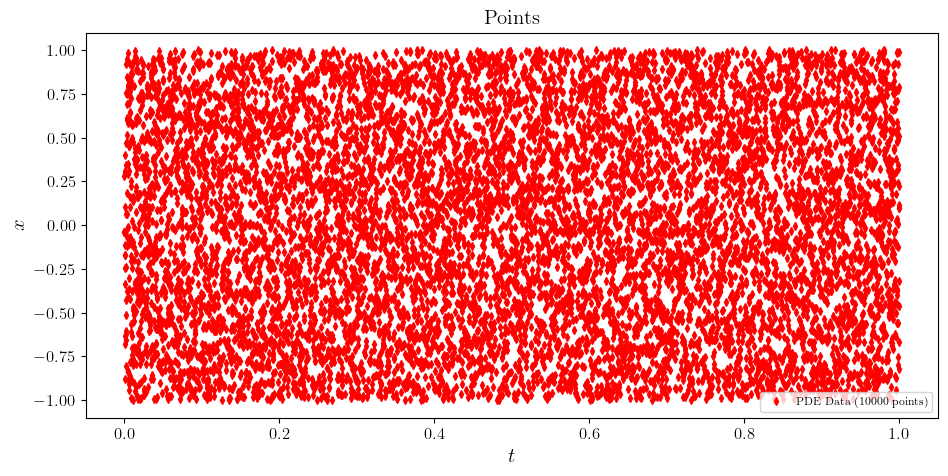

In [11]:

fig = plt.figure(figsize=(11, 5))
ax = fig.add_subplot(1, 1, 1)
#
ax.plot(ptsPDE[:, 0], ptsPDE[:, 1], 
    'rd', label = 'PDE Data (%d points)' % (ptsPDE.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)
#
ax.set_xlabel('$t$', size=15)
ax.set_ylabel('$x$', size=15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.legend()
ax.set_title('Points', fontsize = 15) # font size doubled
ax.tick_params(labelsize=12)
#
plt.show()

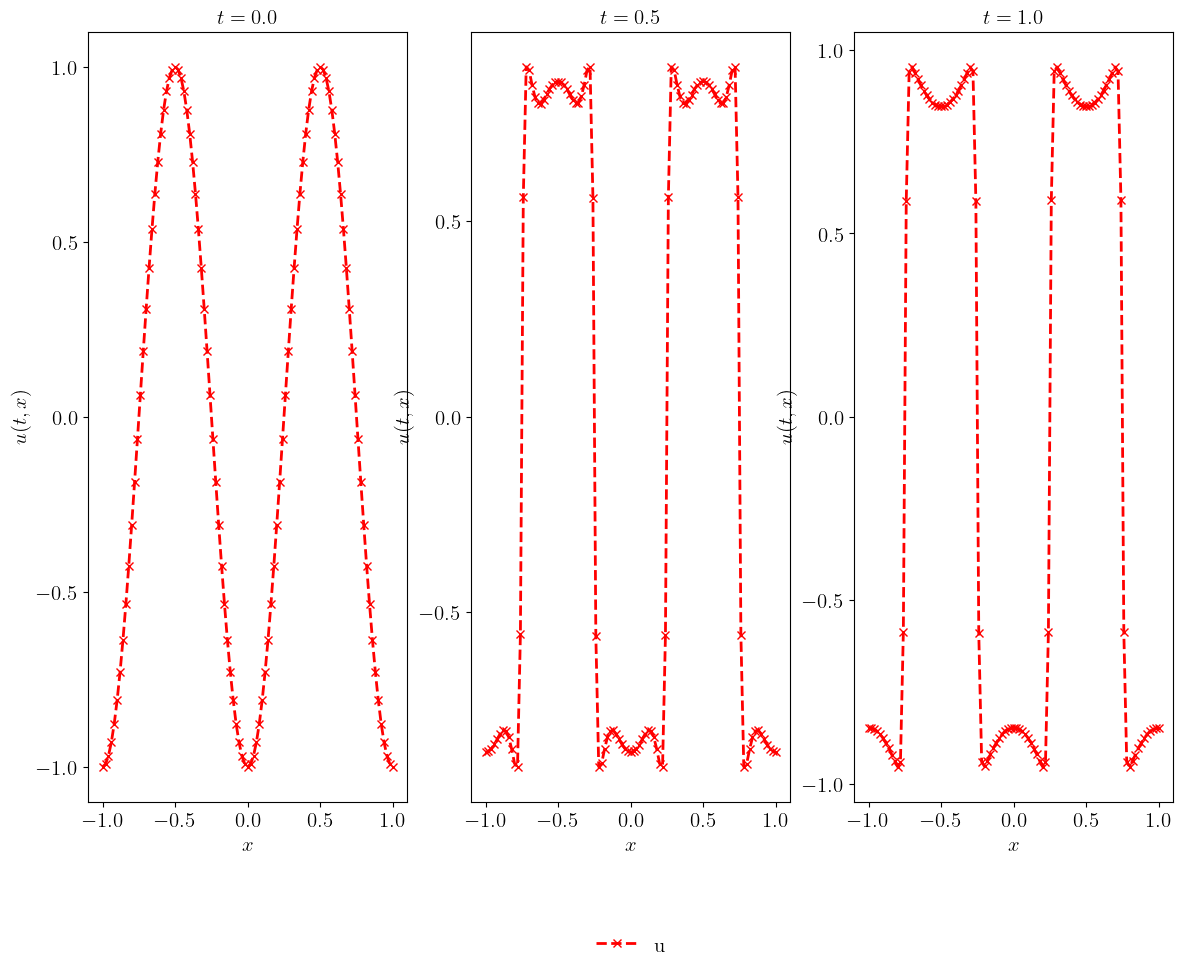

In [12]:


fig = plt.figure(figsize=(18, 6))
#
ax = plt.subplot(1, 3, 1)
ax.plot(x, Exact[0, :], 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 0], 'rx--', linewidth = 2, label = 'u')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = %.1f$' %(t[0]), fontsize = 15)


plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(1, 3, 2)
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')      
ax.plot(x, u_pred[:, 50], 'rx--', linewidth = 2, label = 'u')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')

ax.set_title('$t = %.1f$' %(t[50]), fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(1, 3, 3)
ax.plot(x,Exact[100,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 100], 'rx--', linewidth = 2, label = 'u')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')

ax.set_title('$t = %.1f$' %(t[100]), fontsize = 15)
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

In [ ]:
fig = plt.figure(figsize=(24, 6))

ax = plt.subplot(1, 3, 1)
h = ax.imshow(Exact.T, interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=24) 

cbar.set_ticks([-1,0,1])

ax.set_xlabel('$t$', size=24)
ax.set_ylabel('$x$', size=24)
ax.set_xticks([0 ,0.5 ,1])
ax.set_yticks([-1 ,0 ,1])
ax.set_title('$CH: u_{exact}(t,x)$', fontsize = 24) # font size doubled
ax.tick_params(labelsize=24)

ax = plt.subplot(1, 3, 2)
h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=24) 
cbar.set_ticks([-1,0,1])



ax.set_xlabel('$t$', size=24)

ax.set_xticks([0 ,0.5 ,1])
ax.set_yticks([-1 ,0 ,1])
ax.set_title('$CH: u_{pred}(t,x)$', fontsize = 24) # font size doubled
ax.tick_params(labelsize=24)

ax = plt.subplot(1, 3, 3)
h = ax.imshow(np.abs(u_pred-Exact.T), interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=24) 
#cbar.set_ticks([0,1e-3,2e-3])

# line = np.linspace(x.min(), x.max(), 2)[:,None]
# ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
# ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
# ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=24)

ax.set_xticks([0 ,0.5 ,1])
ax.set_yticks([-1 ,0 ,1])
ax.set_title('$CH(Error): u(t,x)$', fontsize = 24) # font size doubled
ax.tick_params(labelsize=24)


plt.show()
fig.savefig('fig:CH_3.png',format='png')